In [20]:
import numpy as np

In [31]:
doc2vec_features = np.load('doc2vec_features.npy')
doc2vec_features.shape

(18846, 100)

In [32]:
lda_features = np.load('lda_features.npy')
lda_features.shape

(18846, 20)

In [33]:
from sklearn.neighbors import NearestNeighbors

# Assuming lda_vectors and word2vec_vectors are numpy arrays of shape (n_samples, n_features)
# lda_vectors: LDA topic distribution vectors
# word2vec_vectors: word2vec embeddings for the documents

# Combine the LDA and word2vec vectors
combined_vectors = np.hstack((lda_features, doc2vec_features))
combined_vectors.shape


(18846, 120)

knn = NearestNeighbors(n_neighbors=num_points_to_select): Initializes a KNN model specifying that we want to find num_points_to_select neighbors.
knn.fit(combined_vectors): Fits the KNN model to the combined_vectors dataset. The model learns the structure of the data.

In [16]:
# Number of data points to select
num_points_to_select = 500

# Fit the KNN model
knn = NearestNeighbors(n_neighbors=num_points_to_select)
knn.fit(combined_vectors)

# Assuming we want to find neighbors of a specific point
# Here, we take an arbitrary point (e.g., the first point)
distances, indices = knn.kneighbors(combined_vectors[0].reshape(1, -1))

# Range to select any other data point
number_of_documents = combined_vectors.shape[0]
#select data point from range [0, number_of_documents - 1]
# distances, indices = knn.kneighbors(combined_vectors[100].reshape(1, -1))

# Select the indices of the 500 nearest neighbors
selected_indices = indices[0]
selected_data_points = combined_vectors[selected_indices]

# Example: Print selected data points
print("Selected Data Points (first 5):")
print(selected_data_points[:5])

Selected Data Points (first 5):
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  2.15266883e-01  1.69765502e-02  2.80434582e-02
   4.89599079e-01  1.46401571e-02  2.11171731e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  2.05048010e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.25193214e+00  2.74947882e+00  1.59727859e+00 -2.27580285e+00
  -1.34451306e+00 -1.73902202e+00 -1.63118470e+00 -2.08518076e+00
  -5.34472227e-01 -1.18200488e-01  2.40867472e+00 -3.46104860e-01
  -5.46698987e-01  1.03392148e+00 -7.02081203e-01  4.90572691e-01
  -8.18289161e-01  1.10814416e+00 -2.78752446e+00 -2.26783609e+00
   4.75771688e-02  5.90975106e-01  3.53077322e-01 -4.19806510e-01
  -9.77881968e-01  2.79385805e+00 -1.11387193e+00  1.88739347e+00
  -3.46152949e+00 -1.10732210e+00  6.77753270e-01  7.90024474e-02
   1.10571313e+00 -2.28466058e+00 -1.20963216e+00 -9.48602438e-01
  -2.08858991e+00 -2.42820191e+00  6.0830503

**selected_data_point_index**: Index of the data point for which we want to find the nearest neighbors. Here, we arbitrarily choose the first data point (index 0).

**combined_vectors[selected_data_point_index]**: Extracts the vector of the selected data point.

**.reshape(1, -1)**: Reshapes the vector to a 2D array with one row. This is required by the kneighbors method.

**distances, indices = knn.kneighbors(...)**: Finds the nearest neighbors for the selected data point.

Returns:
**distances**: Distances to the nearest neighbors.
**indices**: Indices of the nearest neighbors.

**selected_indices = indices[0]**: Extracts the indices of the nearest neighbors. indices is a 2D array, and indices[0] gives us the 1D array of neighbor indices for our selected data point.

**selected_data_points = combined_vectors[selected_indices]**: Retrieves the vectors of the selected nearest neighbors using the indices.

**print("Selected Data Points (first 5):")**: Prints a header for the selected data points.

**print(selected_data_points[:5])**: Prints the first 5 selected data points for inspection.

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to reduce dimensionality to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
combined_vectors_2d = tsne.fit_transform(combined_vectors)
selected_data_points_2d = combined_vectors_2d[selected_indices]

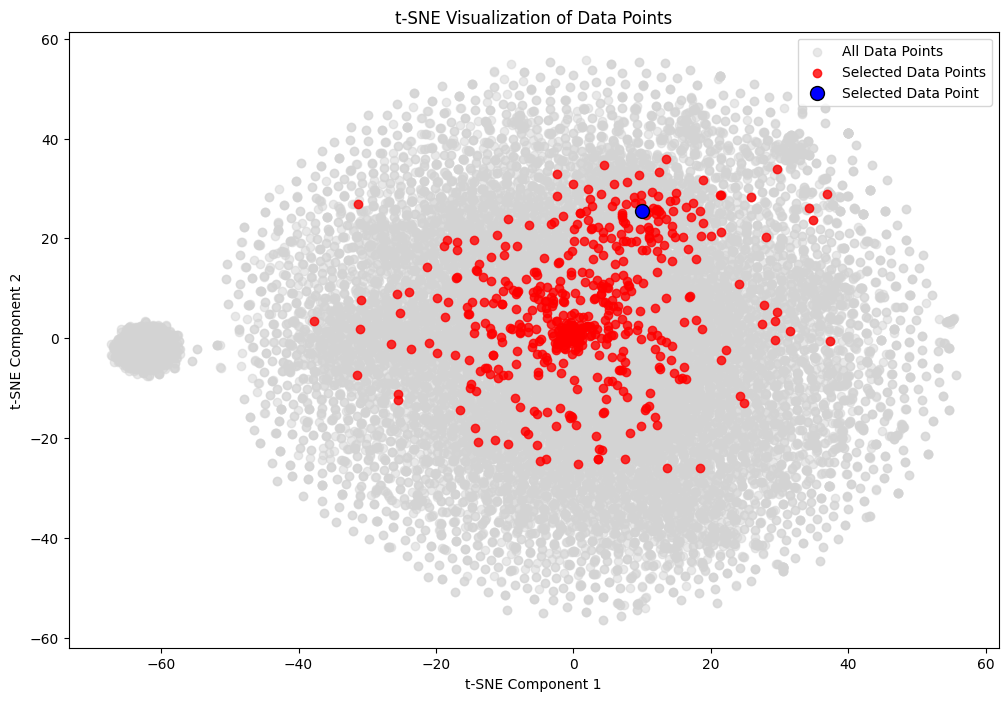

In [19]:
# Plot the original data points and highlight the selected data points
plt.figure(figsize=(12, 8))

# Plot all data points in light grey
plt.scatter(combined_vectors_2d[:, 0], combined_vectors_2d[:, 1], c='lightgrey', label='All Data Points', alpha=0.5)

# Highlight the selected data points in red
plt.scatter(selected_data_points_2d[:, 0], selected_data_points_2d[:, 1], c='red', label='Selected Data Points', alpha=0.8)

# Mark the originally selected point in blue
plt.scatter(combined_vectors_2d[0, 0], combined_vectors_2d[0, 1], c='blue', label='Selected Data Point', edgecolor='black', s=100)

# Add labels and legend
plt.title('t-SNE Visualization of Data Points')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()
